# Link to Implementation

Here is a link to `perceptron.py` on my Github repository: https://github.com/Noah5503/Noah5503.github.io/blob/main/posts/blog-post-5-perceptron/perceptron.py 

# Abstract

The Perceptron algorithm was one of the first examples of a learning algorithm, which iteratively improves by taking small steps towards the optimal solution. Specifically, the Perceptron is capable of separating two classes of data when the data is linearly separable. It accomplishes this by drawing a line, then selecting a random point which is misclassified by that line, and adjusting the line to correct for the misclassification. In this blog post, we will implement the Perceptron algorithm as a class, and test it on several datasets. Notably, we will evaluate its performance on data that is linearly separable, data that is not linearly separable, and multidimensional data outside of visualizable space. 

# How it works

In [2]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
import torch

My implementation of the grad function is as follows:

In [ ]:
def grad(self, X, y):
    scores = self.score(X)
    y_ = 2*y - 1
    misclassified = (scores * y_ < 0).float().unsqueeze(1)
    return torch.sum(misclassified * (y_.unsqueeze(1) * X), dim=0)

The math of the Perceptron update function is as follows: if a point $x_i$ is correctly classified, then make no update based on that point; if $x_i$ is misclassified, then perform the update $w^{(t+1)}$ = $w^{(t)}$ + $(2y_i - 1)*x_i$. In my grad function, the `misclassified` variable is a $n \times 1$ matrix which contains 0s for correctly classified points, and 1s for incorrectly classified points. The grad function returns a vector containing the weight changes, which is equal to $(2y_i - 1)*x_i$ for each misclassified point (correctly classified points will multiply that term by 0, rendering it null). The `torch.sum()` function aggregates these changes to each weight in $w$, so the final returned vector contains the cumulative change for all points in the step.

# Experiments

I have imported the following functions from Phil's lecture notes on 03/12/2025. We will use them to generate data for the algorithm, plot that data using matplotlib, and draw the lines derived from the Perceptron algorithm.

In [3]:
from matplotlib import pyplot as plt # From Phil's Lecture notes
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

To begin, we will generate some linearly separable data. When the data is linearly separable, the Perceptron algorithm will converge to a vector of weights, $w$, which describe a line separating the classes of data. We will know if the algorithm is working or not if it is able to converge on a separating line on this first linearly separable dataset. The `noise` parameter to the `perceptron_data` function controls how spaced the points are allowed to be within a class. By choosing a low `noise` value of 0.2 or 0.3, the data will be more likely to be linearly separable.

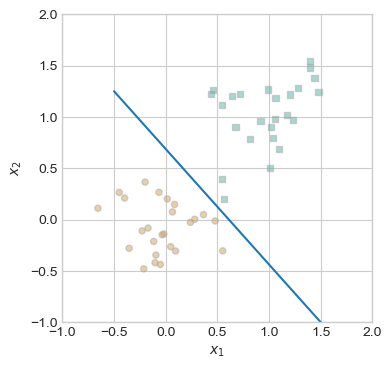

In [6]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
plt.plot([-0.5, 1.5], [1.25, -1.0])
plt.show()

This data is linearly separable, as shown by the blue line which separates the two classes. Therefore, the Perceptron algorithm will be able to converge on a separating line with loss = 0; in other words, it will correctly find a line which separates the two classes. The following code block implements a training loop for the Perceptron, which calculates an update based on 1 point per iteration, repeating until loss = 0. To visualize this process, we will also generate several charts showing the iterations of lines and loss, as well as the point used to make the update.

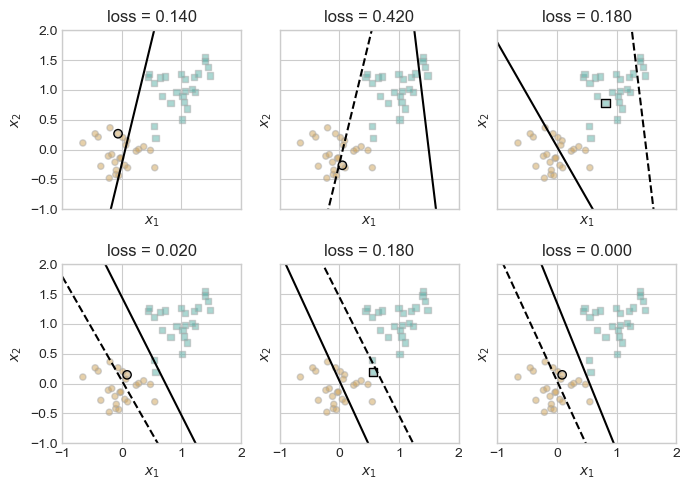

In [74]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

In the top left, we see the initial guess, which then shifted to the right in the top-middle chart, as the highlighted brown circle was selected as the misclassified point for the update. This process repeats with smaller and smaller shifts, until the algorithm successfully converges in the bottom left, drawing a line with zero loss. This optimal solution correctly classifies all points, which was possible since the data was linearly separable. Conversely, if the data is *not* linearly separable, the Perceptron will be unable to converge. To test this, let's generate some data which is not linearly separable, which we can accomplish by increasing the `noise` parameter. This will allow data points to be more loosely grouped, with overlap between the groups.

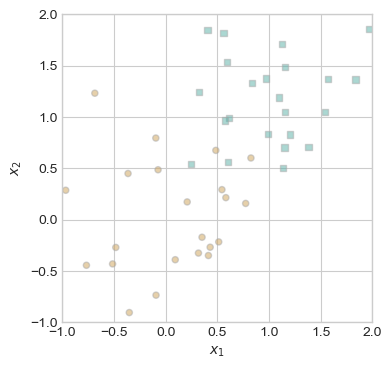

In [10]:
X2, y2 = perceptron_data(n_points = 50, noise=0.6) # Not linearly separable!
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)

This data is not linearly separable, as there is no possible straight line which separates the two classes. This means that the Perceptron algorithm will be unable to converge and achieve loss = 0. However, we can set a maximum number of iterations, which will allow it to reach some local minimum of loss. The following code block implements this process, allowing the Perceptron algorithm to iterate for 1000 steps. It will not achieve zero loss on this dataset, but we may still examine its performance.

In [11]:
p2 = Perceptron()
opt2 = PerceptronOptimizer(p2)
p2.loss(X2, y2)

loss2 = 1.0

loss_vec2 = []

n2 = X2.size()[0]
maxsteps = 1000
j = 0

while (loss2 > 0) and (j < maxsteps):
    
    # not part of the update: just for tracking our progress    
    loss2 = p2.loss(X2, y2) 
    loss_vec2.append(loss2)
    
    # pick a random data point
    i = torch.randint(n2, size = (1,))
    x2_i = X2[[i],:]
    y2_i = y2[i]
    
    # perform a perceptron update using the random data point
    opt2.step(x2_i, y2_i)
    j += 1

The model has now iterated for 1000 steps. To show its progress over the training period, the following code block plots the loss values at each update.

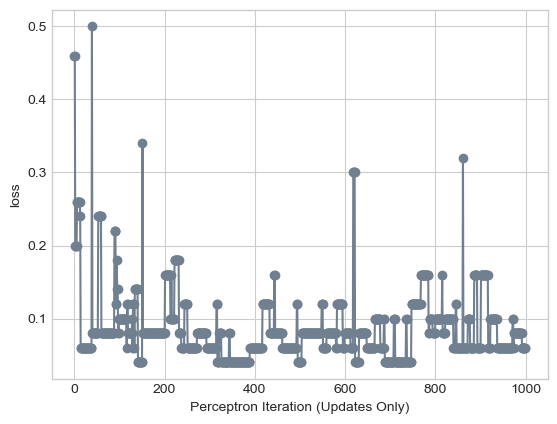

In [12]:
plt.plot(loss_vec2, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec2)), loss_vec2, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

When the data is not linearly separable, the algorithm cannot converge, but we also see that it does not necessarily improve at each step in the training period. This is because at each step, there will exist some set of misclassified points. If the algorithm chooses to update based on a point that is widely misclassified, it will overadjust and make the loss worse. This being said, it still ended up with a relatively low loss value:

In [13]:
print(loss_vec2[-1])

tensor(0.0600)


The final loss is 0.06, which suggests very few misclassified points. Let's plot the data and the final decision line achieved by the Perceptron.

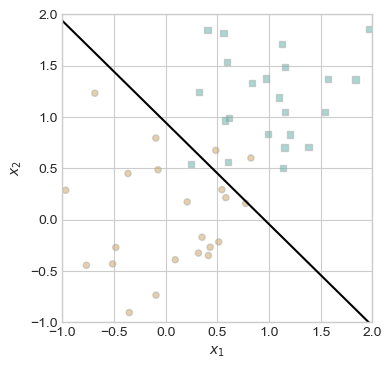

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X2, y2, ax)
draw_line(p2.w, -1, 2, ax, color = "black")

On visual inspection, there appear to be only three misclassified points: two orange circles and one blue square. Despite being unable to converge, this decision line is fairly accurate. 

The Perceptron can also work on data with more than two dimensions. To test this, we will generate a dataset with five dimensions. We will not be able to visualize the data or the decision line created by the algorithm, but we can still plot the loss over time, which will show the algorithm's progress. The following code blocks implement the same process of data generation, training iteration, and plotting the loss over time as seen previously. Notably, we generate data with `noise` = 0.2 to promote linear separability.

In [67]:
X3, y3 = perceptron_data(n_points = 50, noise = 0.2, p_dims = 5)

In [68]:
p3 = Perceptron()
opt3 = PerceptronOptimizer(p3)
p3.loss(X3, y3)

loss3 = 1.0

loss_vec3 = []

n3 = X3.size()[0]
maxsteps = 1000
j = 0

while (loss3 > 0) and (j < maxsteps):
    
    # not part of the update: just for tracking our progress    
    loss3 = p3.loss(X3, y3) 
    loss_vec3.append(loss3)
    
    # pick a random data point
    i = torch.randint(n3, size = (1,))
    x3_i = X3[[i],:]
    y3_i = y3[i]
    
    # perform a perceptron update using the random data point
    opt3.step(x3_i, y3_i)
    j += 1

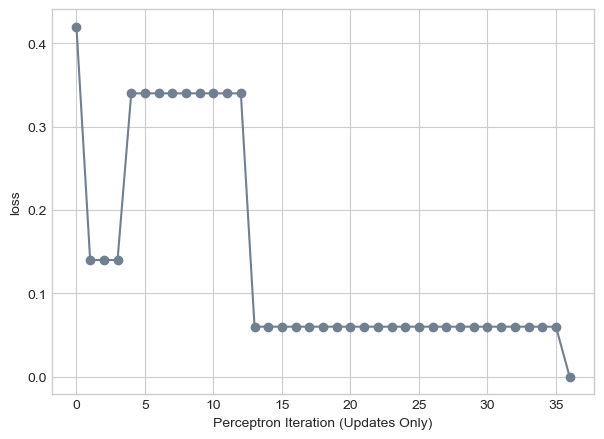

In [69]:
plt.plot(loss_vec3, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec3)), loss_vec3, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Given this chart, the Perceptron was able to converge to loss = 0, even on five dimensional data. On the 36th iteration, the loss dropped from 0.06 to 0.00. This suggests that the dataset must have been linearly separable, as zero loss would not be possible otherwise.

# Discussion

To determine the runtime of a single iteration of the Perceptron algorithm, let's take a look at the `step()` method of the `PerceptronOptimizer` class.

In [ ]:
def step(self, X, y):
    current_loss = self.model.loss(X, y)
    gradient = self.model.grad(X, y)
    self.model.w += gradient
    return current_loss

There are three lines of computation in this function. Line 3 adds the result of `Perceptron.grad()` to the weight vector `w`, which is a $p \times 1$ vector. Performing this addition, therefore, requires $p$ operations, so this line is $O(p)$, where $p$ is the number of dimensions in the dataset. Lines 1 and 2 both involve computing the current loss, which is the number of misclassified points. This amounts to performing the matrix multiplication `X@w` and checking whether the results are correctly classified or not. The running time of this operation is $O(n \times p) + O(n)$, as the matrix multiplication takes $n \times p$ steps, and checking the results takes $n$ steps. Therefore, the running time of the entire `step()` function is $O(n \times p) + O(n) + O(p)$, which is the same as $O(n \times p)$.

While the Perceptron algorithm may be dated and relatively low in power, it still marks an important concept in machine learning, which is using iterative learning approaches to optimize some value. By updating the decision line based on a misclassified point, the simple Perceptron model is able to converge to a correct classification line on linearly separable data, even with large numbers of dimensions. More powerful algorithms such as logistic regressions build on this approach by iteratively optimizing convex loss functions, which allow for more powerful classifications. Implementing more complex learning algorithms will be a focus in future work, but the Perceptron serves as an easy to understand starting point.